# Multiclass Image Classification using CNN

Multiclass image classfication using Convolutional Neural Network impelemented using Pytorch

## Necessary Imports

Import the following libraries

* torch             - Pytorch library
* torch.nn          - Pytorch's neural network class
* torch.nn.functional - Pytorch's neural network functional API
* torch.utils.data.DataLoader - Pytorch's data loader to load images in batches, to shuffle, etc.
* torch.utils.make_grid - To display set of iamges as a grid
* torchvision.datasets - Pytorch's dataset class for downloading standard datasets like MNIST, CIFAR10, etc
* torchvision.transforms - To transform images to tensors using pytorch's DataLoader
* numpy             - Library for performing linear algebra operations
* matplotlib        - Library to visualise data and metrics
* sklearn.metrics.classification_report - To get Classfication Report of our classifier
* sklearn.metrics.confusion_matrix - To get Confusion Matrix of our classifier
* pandas - Library to read and perform operations with csv, excel sheets, etc.
* seaborn - For sophisticated visualization
* time - Python's builtin library for getting time and operations on it

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
transform = transforms.ToTensor()

In [3]:
train = datasets.CIFAR10(root='../Course/Data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [4]:
test = datasets.CIFAR10(root='../Course/Data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [5]:
train_loader = DataLoader(train, batch_size=100, shuffle=True)
test_loader = DataLoader(test, batch_size=200, shuffle=False)

In [6]:
LABELS = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
for images, labels in train_loader:
    break

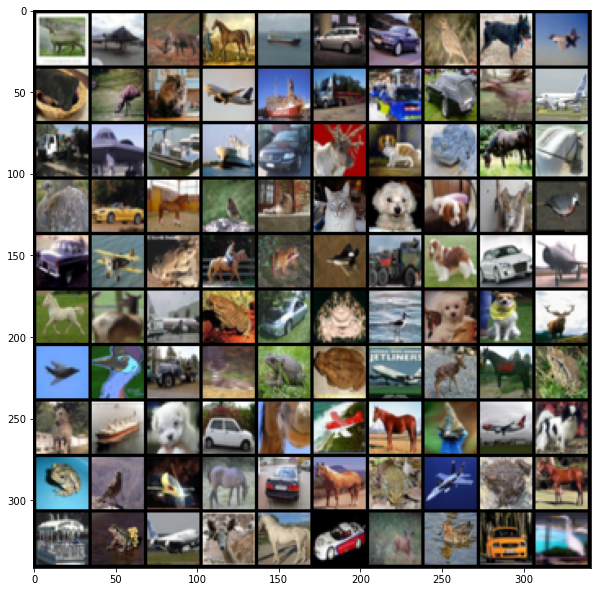

In [8]:
plt.figure(figsize=(10,40))
img = make_grid(images, nrow=10)
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

In [9]:
class CNN(nn.Module):
    def __init__(self):
        # subclass torch's nn Module
        super().__init__()
        
        # Feature extraction layers
        # Convolutional Layer 1 
        self.conv_layer1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
                                         nn.BatchNorm2d(64),
                                         nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2),
                                         nn.BatchNorm2d(64),
                                         nn.LeakyReLU(negative_slope=0.3, inplace=True),
                                         nn.MaxPool2d(2, 2))
        
        # Convolutional Layer 2
        self.conv_layer2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
                                         nn.BatchNorm2d(128),
                                         nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2),
                                         nn.BatchNorm2d(128),
                                         nn.LeakyReLU(negative_slope=0.3, inplace=True),
                                         nn.MaxPool2d(2, 2))
        
        # Convolutional Layer 3
        self.conv_layer3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
                                         nn.BatchNorm2d(256),
                                         nn.Conv2d(256, 256, kernel_size=5, stride=1, padding=2),
                                         nn.BatchNorm2d(256),
                                         nn.Conv2d(256, 256, kernel_size=5, stride=1, padding=2),
                                         nn.BatchNorm2d(256),
                                         nn.LeakyReLU(negative_slope=0.3, inplace=True),
                                         nn.MaxPool2d(2, 2))
        
        # Convolutional Layer 4
        self.conv_layer4 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=2),
                                         nn.BatchNorm2d(512),
                                         nn.Conv2d(512, 512, kernel_size=5, stride=1, padding=2),
                                         nn.BatchNorm2d(512),
                                         nn.Conv2d(512, 512, kernel_size=5, stride=1, padding=2),
                                         nn.BatchNorm2d(512),
                                         nn.LeakyReLU(negative_slope=0.3, inplace=True),
                                         nn.MaxPool2d(2, 2))
        
        # Convolutional Layer 5
        self.conv_layer5 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=5, stride=1, padding=2),
                                         nn.BatchNorm2d(512),
                                         nn.Conv2d(512, 512, kernel_size=5, stride=1, padding=2),
                                         nn.BatchNorm2d(512),
                                         nn.Conv2d(512, 512, kernel_size=5, stride=1, padding=2),
                                         nn.BatchNorm2d(512),
                                         nn.LeakyReLU(negative_slope=0.3, inplace=True),
                                         nn.MaxPool2d(2, 2))
        
        # Output layers
        # Fully Connected Layer for Classifier
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(1 * 1 * 512, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        
    def forward(self, X):
        # perform convolution using all five convolution layers
        X = self.conv_layer1(X)
        X = self.conv_layer2(X)
        X = self.conv_layer3(X)
        X = self.conv_layer4(X)
        X = self.conv_layer5(X)
        
        # flatten or reshape into a column of extracted features
        X = X.reshape(X.size(0), -1)
        
        # pass through fully connected layer
        X = F.leaky_relu(self.fc1(X), negative_slope=0.3)
        X = self.dropout(X)
        X = F.leaky_relu(self.fc2(X), negative_slope=0.3)
        X = self.dropout(X)
        X = F.leaky_relu(self.fc3(X), negative_slope=0.3)
        
        # return softmax probabilities 
        return F.log_softmax(X, dim=1)

In [10]:
model = CNN().cuda()

In [11]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.003)
epochs = 30
losses = []
val_losses = []
correct = []
val_correct = []

In [12]:
start_time = time.time()

for e in range(epochs):
    train_corr = 0
    val_corr = 0
    
    # train in batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        
        # perform single forward pass per batch iteration
        y_hat = model(X_train)
        loss = criterion(y_hat, y_train)
        
        pred = torch.max(y_hat.data, 1)[1]
        batch_corr = (pred == y_train).sum()
        train_corr += batch_corr
        
        # back propagation
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        # display training metrics
        if b%500 == 0:
            accuracy = train_corr.item()*100/(100*b)
            print("Epoch {}".format(e+1, b))
            print("Accuracy: {:.4f}  Loss: {:.4f}".format(accuracy, loss))
    
    losses.append(loss)
    correct.append(train_corr)
    
    # perform validation every epoch
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.cuda()
            y_test = y_test.cuda()
            
            y_val = model(X_test)
            pred = torch.max(y_val, 1)[1]
            val_corr += (pred == y_test).sum()
    
    val_loss = criterion(y_val, y_test)
    val_losses.append(val_loss)
    val_correct.append(val_corr)

end_time = time.time() - start_time

print("\nTraining Duration {:.4f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

Epoch 1
Accuracy: 19.6920  Loss: 1.8100
Epoch 2
Accuracy: 31.4160  Loss: 1.6230
Epoch 3
Accuracy: 38.5740  Loss: 1.6578
Epoch 4
Accuracy: 47.3860  Loss: 1.1964
Epoch 5
Accuracy: 58.0940  Loss: 1.0119
Epoch 6
Accuracy: 62.0300  Loss: 1.0682
Epoch 7
Accuracy: 65.1300  Loss: 0.9980
Epoch 8
Accuracy: 67.3360  Loss: 0.8934
Epoch 9
Accuracy: 69.7620  Loss: 0.8704
Epoch 10
Accuracy: 71.9960  Loss: 0.6478
Epoch 11
Accuracy: 73.6440  Loss: 0.8609
Epoch 12
Accuracy: 74.5460  Loss: 0.5992
Epoch 13
Accuracy: 76.0560  Loss: 0.7929
Epoch 14
Accuracy: 77.1040  Loss: 0.5928
Epoch 15
Accuracy: 78.6900  Loss: 0.7723
Epoch 16
Accuracy: 79.5320  Loss: 0.6411
Epoch 17
Accuracy: 80.4600  Loss: 0.6456
Epoch 18
Accuracy: 81.3640  Loss: 0.4951
Epoch 19
Accuracy: 82.1260  Loss: 0.5565
Epoch 20
Accuracy: 83.3700  Loss: 0.5963
Epoch 21
Accuracy: 83.5720  Loss: 0.4159
Epoch 22
Accuracy: 84.4880  Loss: 0.4290
Epoch 23
Accuracy: 85.2140  Loss: 0.4761
Epoch 24
Accuracy: 85.8420  Loss: 0.6649
Epoch 25
Accuracy: 86.628

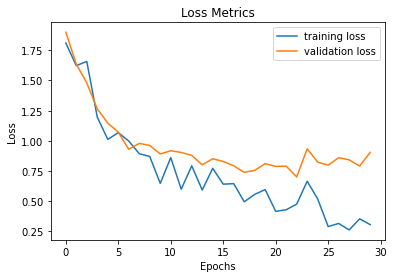

In [13]:
plt.plot(range(epochs), losses, label='training loss')
plt.plot(range(epochs), val_losses, label='validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

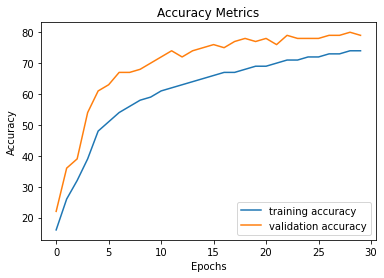

In [14]:
acc = [train_corr/600 for train_corr in correct]
val_acc = [test_corr/100 for test_corr in val_correct]
plt.plot(range(epochs), acc, label='training accuracy')
plt.plot(range(epochs), val_acc, label='validation accuracy')
plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [15]:
test_load_all = DataLoader(test, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test = X_test.cuda()
        y_test = y_test.cuda()
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, LABELS, LABELS)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.show()

RuntimeError: CUDA out of memory. Tried to allocate 2.44 GiB (GPU 0; 4.00 GiB total capacity; 758.45 MiB already allocated; 1.57 GiB free; 1.36 GiB reserved in total by PyTorch)

In [ ]:
print(f"Clasification Report\n\n{classification_report(y_test.view(-1).cpu(), predicted.view(-1).cpu())}")

In [ ]:
torch.save(model.state_dict(), 'models/cifar.pt')